# Downloading Libraries


In [1]:
! pip install nltk
! pip install vaderSentiment
! pip install pytrends
! pip install textblob
! pip install wordcloud
! pip install gensim
! pip install seaborn
! pip install TextBlob
! pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importing Libraries


In [2]:
import nltk
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet', quiet=True)

[nltk_data] Downloading package punkt to C:\Users\Edward
[nltk_data]     Zavala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Edward
[nltk_data]     Zavala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Edward
[nltk_data]     Zavala\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Importing Dataset

In [4]:
df = pd.read_csv('Dataset/Cleaned Data/reviews.csv', encoding='latin1')
df.head()

,date,reviewer_name,comments,cleaned_comments,polarity,sentiment
0,2016-08-20,Jenny,"Die Unterkunft war wirklicht toll, ruhig, nett...",die unterkunft war wirklicht toll ruhig nett z...,-0.7,negative
1,2023-01-08,Elia,"El apartamento estaba correcto, tal cual, como...",el apartamento estaba correcto tal cual como e...,-0.6,negative
2,2023-05-02,Cecilia,Yo buscaba estar cerca de la estaciÃ³n de Live...,yo buscaba estar cerca de la estaciÃ³n de live...,-0.6,negative
3,2018-11-25,Sibylle,"Elisas Wohnung liegt in Hampsted, mehrere Busl...",elisa wohnung liegt hampst mehrer buslinien ha...,-0.7,negative
4,2018-02-18,Nathalie,Ich habe meinen Aufenthalt bei Hedge und Britt...,ich habe meinen aufenthalt bei hedg und britt ...,-0.7,negative


# Date Preprocessing


In [5]:
df.isnull().sum()

date                0
reviewer_name       0
comments            0
cleaned_comments    0
polarity            0
sentiment           0
dtype: int64

In [6]:
# Dropping the null values
df.dropna(inplace=True)
df.isnull().sum()

date                0
reviewer_name       0
comments            0
cleaned_comments    0
polarity            0
sentiment           0
dtype: int64

# Exploratory Data Analysis


In [7]:
# Check which columns exist
print(df.columns)


Index(['date', 'reviewer_name', 'comments', 'cleaned_comments', 'polarity',
       'sentiment'],
      dtype='object')


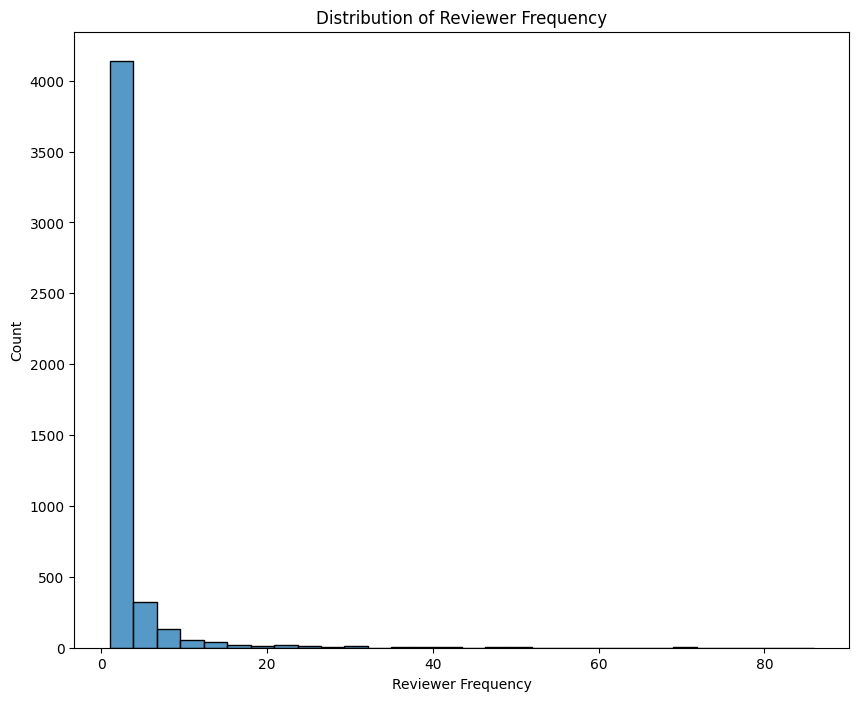

In [8]:
# Define reviewer frequency (how many reviews each reviewer left)
reviewer_freq = df['reviewer_name'].value_counts()

# Plot the distribution of reviewer frequency using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(reviewer_freq, bins=30, kde=False)  # Using histplot instead of deprecated distplot
plt.title('Distribution of Reviewer Frequency')
plt.xlabel('Reviewer Frequency')
plt.ylabel('Count')
plt.show()



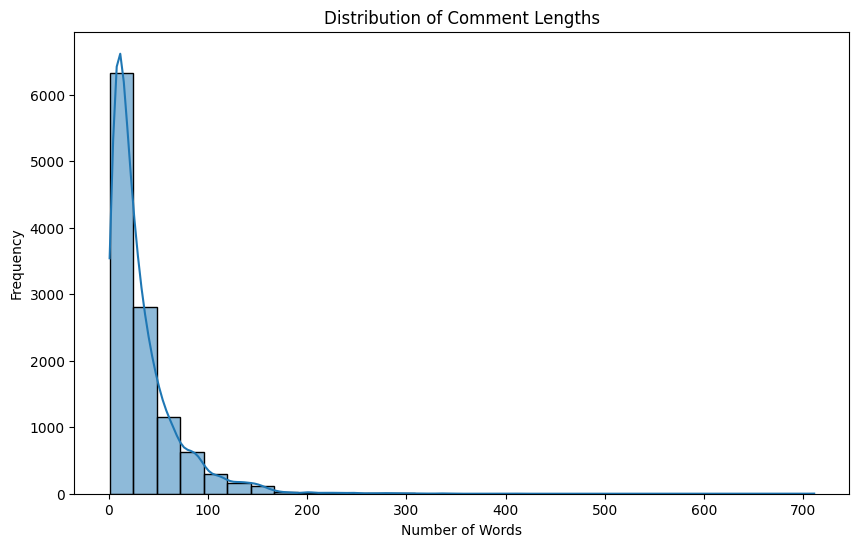

In [9]:
df['comment_length'] = df['cleaned_comments'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_length'], bins=30, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

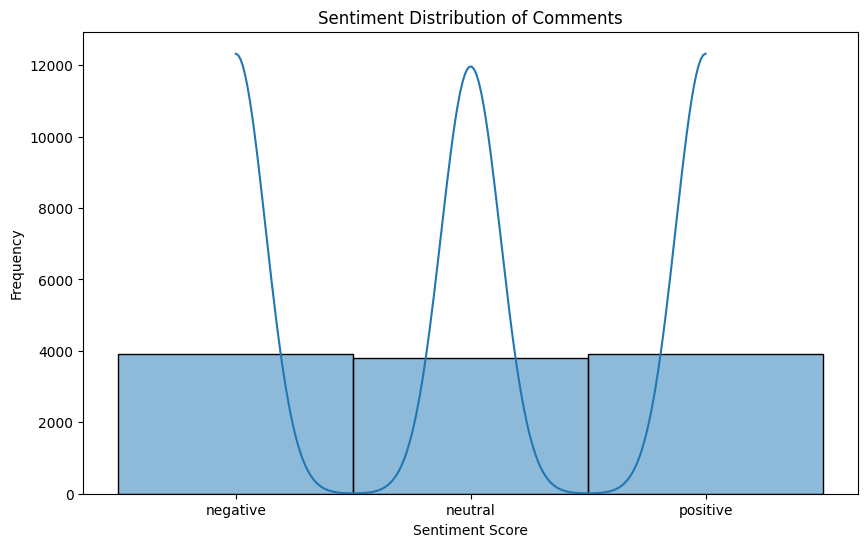

In [10]:
# Visualizing Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution of Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

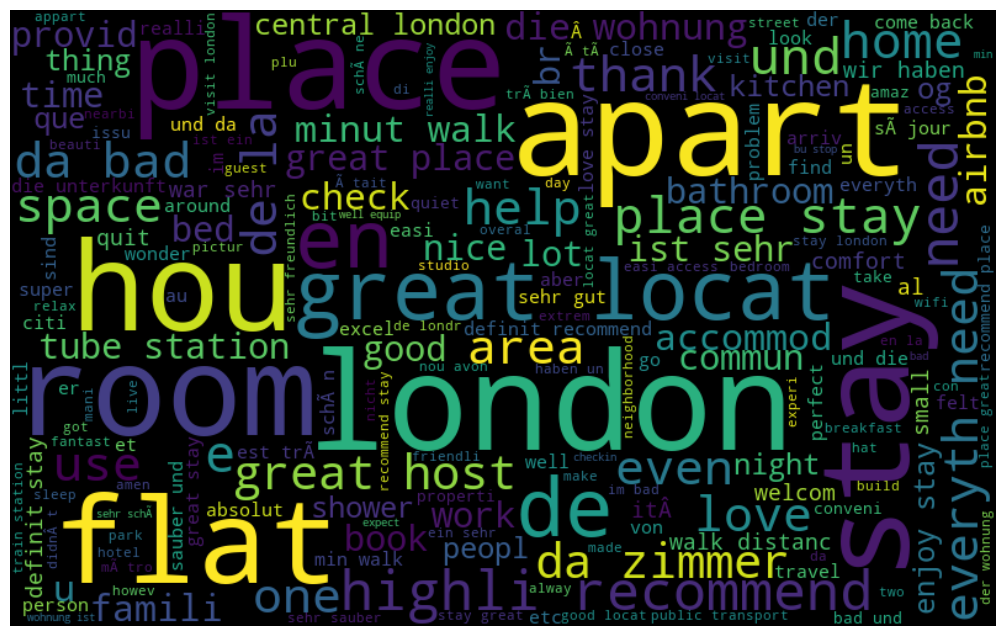

In [11]:
# Word Frequency Analysis
all_words = ' '.join([text for text in df['cleaned_comments']])
wordcloud = WordCloud(width=800, height=500, random_state=21,
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

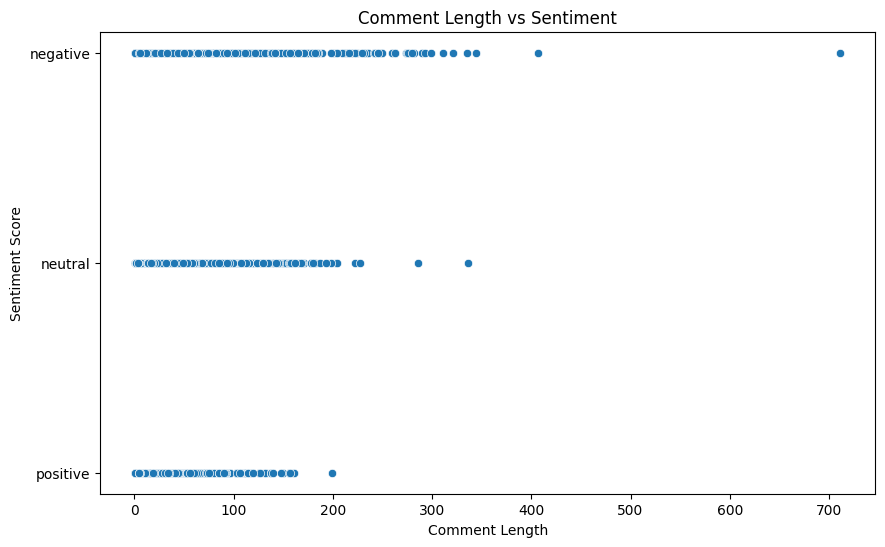

In [12]:
# Comment Length vs Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='comment_length', y='sentiment', data=df)
plt.title('Comment Length vs Sentiment')
plt.xlabel('Comment Length')
plt.ylabel('Sentiment Score')
plt.show()

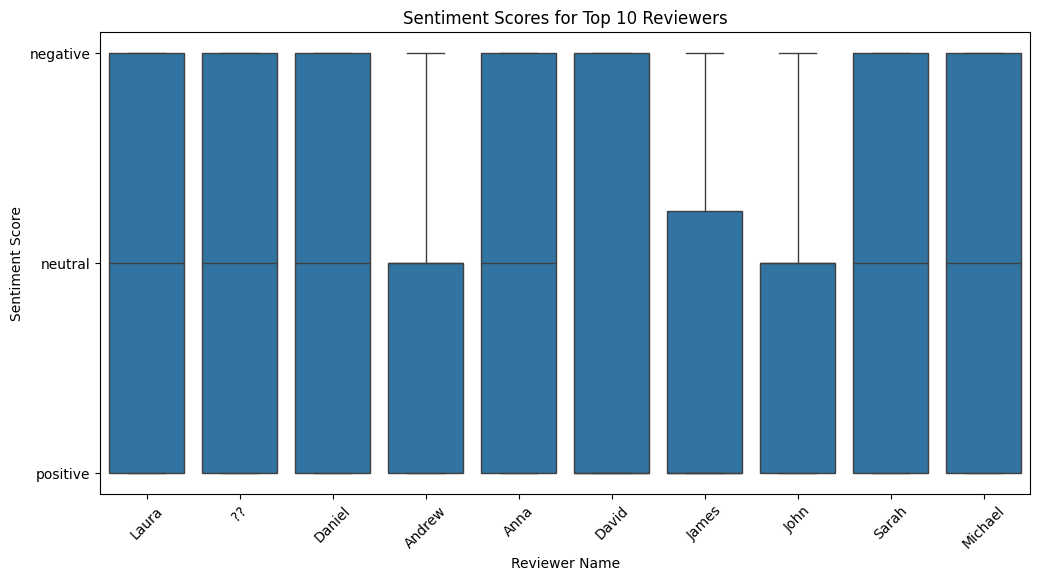

In [13]:
# Reviewer Frequency and Sentiment
# Top 10 reviewers
top_reviewers = df['reviewer_name'].value_counts().head(10).index
top_reviewers_df = df[df['reviewer_name'].isin(top_reviewers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='reviewer_name', y='sentiment', data=top_reviewers_df)
plt.xticks(rotation=45)
plt.title('Sentiment Scores for Top 10 Reviewers')
plt.xlabel('Reviewer Name')
plt.ylabel('Sentiment Score')
plt.show()

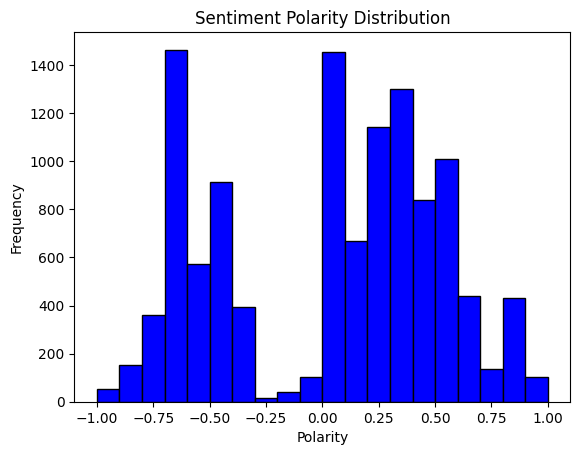

In [14]:
# Plot histogram
plt.hist(df['polarity'], bins=20, color='blue', edgecolor='black')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

## **<center><u>Assessment: Experimentations (using Machine Learning)</u></center>**


In [15]:
# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_comments'])

In [16]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, df['sentiment'], test_size=0.2, random_state=42)

In [17]:
print("Features X_train:")
X_train

Features X_train:


<9270x30225 sparse matrix of type '<class 'numpy.float64'>'
	with 259925 stored elements in Compressed Sparse Row format>

In [18]:
print("Features X_test:")
X_test

Features X_test:


<2318x30225 sparse matrix of type '<class 'numpy.float64'>'
	with 65077 stored elements in Compressed Sparse Row format>

In [19]:
print("Features y_train:")
y_train

Features y_train:


2030     negative
9847     positive
7401      neutral
4574      neutral
4219      neutral
           ...   
11284    positive
5191      neutral
5390      neutral
860      negative
7270      neutral
Name: sentiment, Length: 9270, dtype: object

In [20]:
print("Features y_test:")
y_test

Features y_test:


6861      neutral
9774     positive
1272     negative
5118      neutral
9696     positive
           ...   
788      negative
6935      neutral
3379     negative
11086    positive
4245      neutral
Name: sentiment, Length: 2318, dtype: object

# 1. Logistic Regression


In [21]:
print("Evaluation for: Logistic Regression Classifier".center(80, '_'))

lgc = LogisticRegression()
lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_test)
lgc_acc = accuracy_score(y_test, lgc_pred)
lgc_prec = precision_score(y_test, lgc_pred, average='weighted')
lgc_rec = recall_score(y_test, lgc_pred, average='weighted')
lgc_f1 = f1_score(y_test, lgc_pred, average='weighted')

print(f"Model Type: {lgc}")
print("\n" + f"Prediciton: {lgc_pred}")
print('-' * 80)

print(f"Accuracy Score:  {(lgc_acc):%}")
print(f"Precision Score: {(lgc_prec):%}")
print(f"Recall Score:    {(lgc_rec):%}")
print(f"F1-Score:        {(lgc_f1):%}")

_________________Evaluation for: Logistic Regression Classifier_________________
Model Type: LogisticRegression()

Prediciton: ['neutral' 'positive' 'neutral' ... 'negative' 'positive' 'neutral']
--------------------------------------------------------------------------------
Accuracy Score:  88.050043%
Precision Score: 88.104230%
Recall Score:    88.050043%
F1-Score:        88.018127%


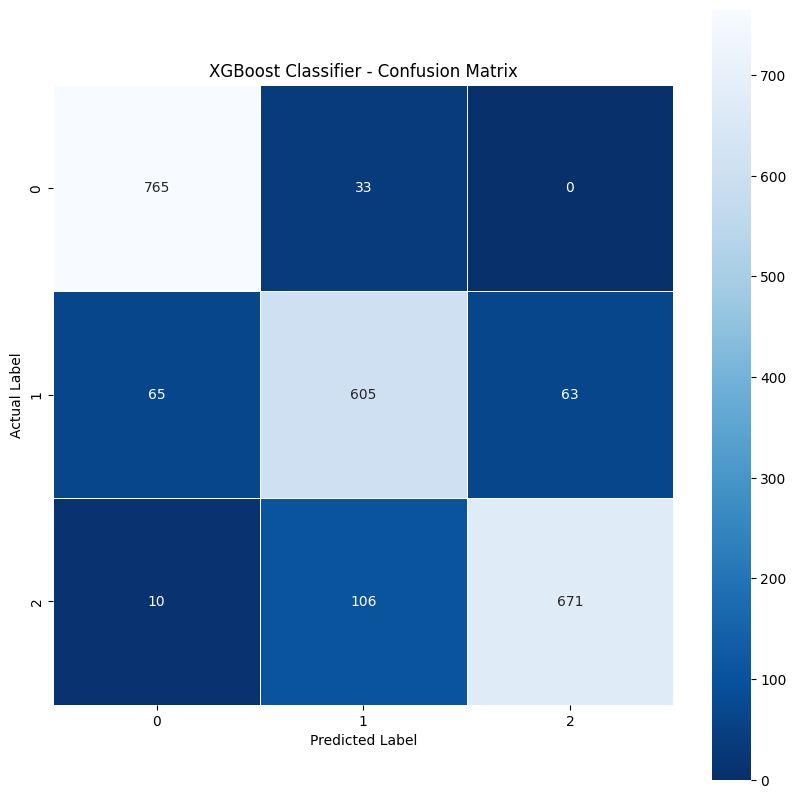

In [22]:
# Plotting the Confusion Matrix:
lgc_confusion_matrix = confusion_matrix(y_test, lgc_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(lgc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("XGBoost Classifier - Confusion Matrix")
plt.show()

In [23]:
print("Classification Report For XGBoost Classifier:")
print('-' * 57)
print(classification_report(y_test, lgc_pred))

Classification Report For XGBoost Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.91      0.96      0.93       798
     neutral       0.81      0.83      0.82       733
    positive       0.91      0.85      0.88       787

    accuracy                           0.88      2318
   macro avg       0.88      0.88      0.88      2318
weighted avg       0.88      0.88      0.88      2318



In [24]:
# save the logistic regression model
joblib.dump(lgc, 'Models/logistic_regression_model.pkl')

['Models/logistic_regression_model.pkl']

In [25]:
# save the vectorizer
joblib.dump(vectorizer, 'Models/tfidf_vectorizer.pkl')

['Models/tfidf_vectorizer.pkl']

# 2. AdaBoost Classifier


In [26]:
print("Evaluation for: AdaBoost Classifier".center(57, '_'))

abc = AdaBoostClassifier()

abc.fit(X_train, y_train)

abc_prediction = abc.predict(X_test)
abc_accuracy_score = accuracy_score(y_test, abc_prediction)
abc_precision_score = precision_score(
    y_test, abc_prediction, average="weighted")
abc_recall_score = recall_score(y_test, abc_prediction, average="weighted")
abc_f1_score = f1_score(y_test, abc_prediction, average="weighted")

print(f"Model Type: {abc}")
print(f"Prediciton: {abc_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(abc_accuracy_score):%}")
print(f"Precision Score: {(abc_precision_score):%}")
print(f"Recall Score:    {(abc_recall_score):%}")
print(f"F1-Score:        {(abc_f1_score):%}")

___________Evaluation for: AdaBoost Classifier___________
Model Type: AdaBoostClassifier()
Prediciton: ['neutral' 'neutral' 'negative' ... 'negative' 'positive' 'neutral']
---------------------------------------------------------
Accuracy Score:  74.374461%
Precision Score: 78.308085%
Recall Score:    74.374461%
F1-Score:        75.287321%


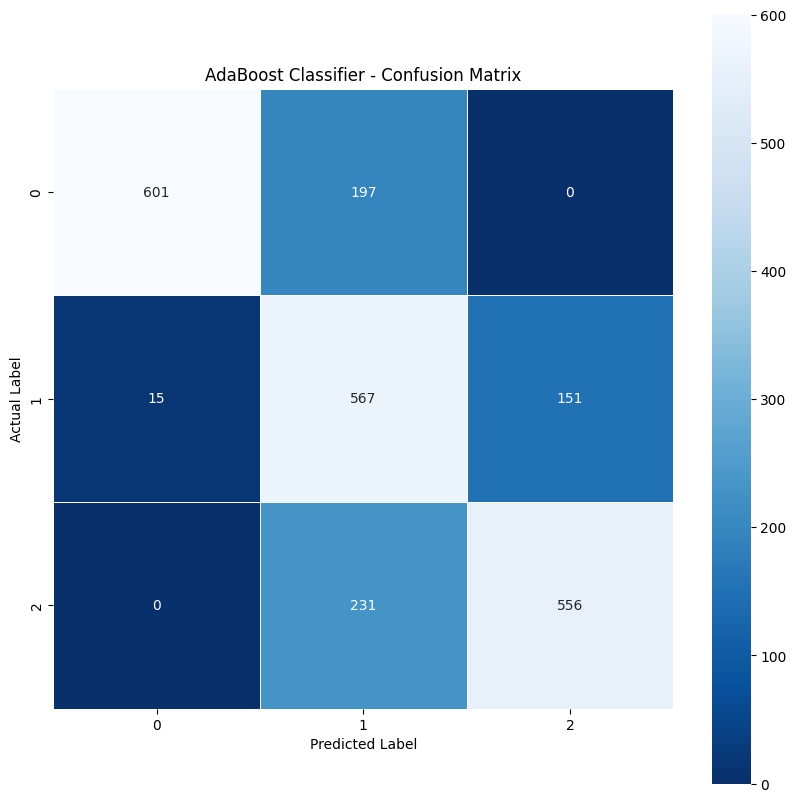

In [27]:
# Plotting the Confusion Matrix:
abc_confusion_matrix = confusion_matrix(y_test, abc_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(abc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("AdaBoost Classifier - Confusion Matrix")
plt.show()

In [28]:
print("Classification Report For AdaBoost Classifier:")
print('-' * 57)
print(classification_report(y_test, abc_prediction))

Classification Report For AdaBoost Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.98      0.75      0.85       798
     neutral       0.57      0.77      0.66       733
    positive       0.79      0.71      0.74       787

    accuracy                           0.74      2318
   macro avg       0.78      0.74      0.75      2318
weighted avg       0.78      0.74      0.75      2318



In [29]:
# save the logistic regression model
joblib.dump(abc, 'Models/ada_boost_model.pkl')

['Models/ada_boost_model.pkl']

# 3. K-Nearest Neighbors


In [30]:
print("Evaluation for: K-Neighbors Classifier".center(57, '_'))

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

knn_prediction = knn.predict(X_test)
knn_accuracy_score = accuracy_score(y_test, knn_prediction)
knn_precision_score = precision_score(
    y_test, knn_prediction, average="weighted")
knn_recall_score = recall_score(y_test, knn_prediction, average="weighted")
knn_f1_score = f1_score(y_test, knn_prediction, average="weighted")

print(f"Model Type: {knn}")
print(f"Prediciton: {knn_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(knn_accuracy_score):%}")
print(f"Precision Score: {(knn_precision_score):%}")
print(f"Recall Score:    {(knn_recall_score):%}")
print(f"F1-Score:        {(knn_f1_score):%}")

__________Evaluation for: K-Neighbors Classifier_________
Model Type: KNeighborsClassifier()
Prediciton: ['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
---------------------------------------------------------
Accuracy Score:  37.402934%
Precision Score: 76.469691%
Recall Score:    37.402934%
F1-Score:        26.626755%


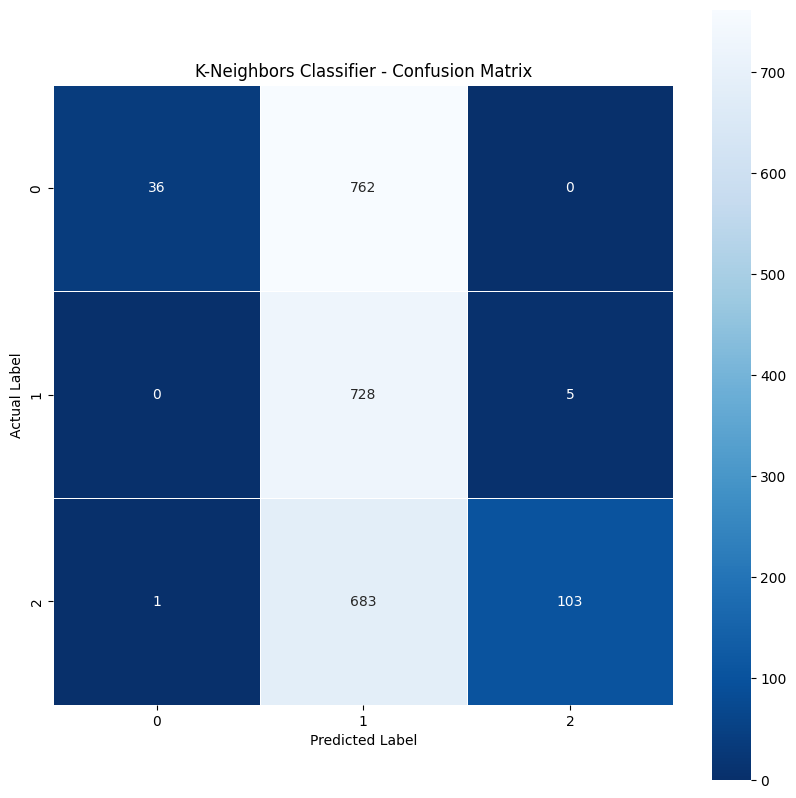

In [31]:
# Plotting the Confusion Matrix:
knn_confusion_matrix = confusion_matrix(y_test, knn_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(knn_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("K-Neighbors Classifier - Confusion Matrix")
plt.show()

In [32]:
print("Classification Report For K-Neighbors Classifier:")
print('-' * 57)
print(classification_report(y_test, knn_prediction))

Classification Report For K-Neighbors Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.97      0.05      0.09       798
     neutral       0.34      0.99      0.50       733
    positive       0.95      0.13      0.23       787

    accuracy                           0.37      2318
   macro avg       0.75      0.39      0.27      2318
weighted avg       0.76      0.37      0.27      2318



In [33]:
# save the k-neighbors model
joblib.dump(knn, 'Models/k_neighbors_model.pkl')

['Models/k_neighbors_model.pkl']

# 4. Decision Tree Classifier


In [34]:
print("Evaluation for: Decision Tree Classifier".center(57, '_'))

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

dtc_prediction = dtc.predict(X_test)
dtc_accuracy_score = accuracy_score(y_test, dtc_prediction)
dtc_precision_score = precision_score(
    y_test, dtc_prediction, average="weighted")
dtc_recall_score = recall_score(y_test, dtc_prediction, average="weighted")
dtc_f1_score = f1_score(y_test, dtc_prediction, average="weighted")

print(f"Model Type: {dtc}")
print(f"Prediciton: {dtc_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(dtc_accuracy_score):%}")
print(f"Precision Score: {(dtc_precision_score):%}")
print(f"Recall Score:    {(dtc_recall_score):%}")
print(f"F1-Score:        {(dtc_f1_score):%}")

_________Evaluation for: Decision Tree Classifier________
Model Type: DecisionTreeClassifier()
Prediciton: ['neutral' 'positive' 'negative' ... 'negative' 'positive' 'neutral']
---------------------------------------------------------
Accuracy Score:  86.755824%
Precision Score: 86.756578%
Recall Score:    86.755824%
F1-Score:        86.750718%


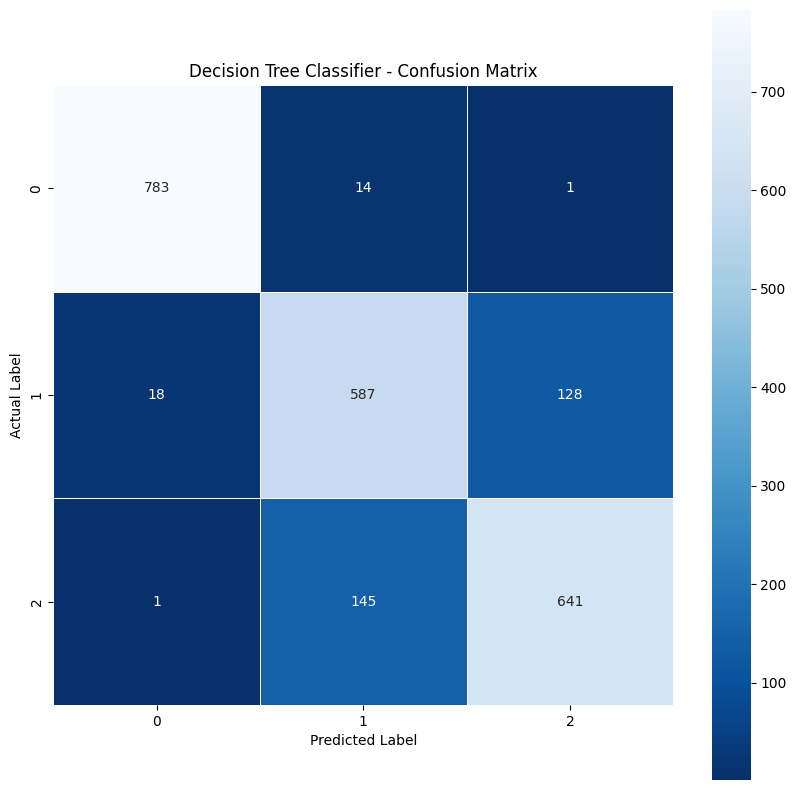

In [35]:
# Plotting the Confusion Matrix:
dtc_confusion_matrix = confusion_matrix(y_test, dtc_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(dtc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Decision Tree Classifier - Confusion Matrix")
plt.show()

In [36]:
print("Classification Report For Decision Tree Classifier:")
print('-' * 57)
print(classification_report(y_test, dtc_prediction))

Classification Report For Decision Tree Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.98      0.98      0.98       798
     neutral       0.79      0.80      0.79       733
    positive       0.83      0.81      0.82       787

    accuracy                           0.87      2318
   macro avg       0.87      0.87      0.87      2318
weighted avg       0.87      0.87      0.87      2318



In [37]:
# save the decision tree model
joblib.dump(dtc, 'Models/decision_tree_model.pkl')

['Models/decision_tree_model.pkl']

# 5. Random Forest Classifier


In [38]:
print("Evaluation for: Random Forest Classifier".center(57, '_'))

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc_prediction = rfc.predict(X_test)
rfc_accuracy_score = accuracy_score(y_test, rfc_prediction)
rfc_precision_score = precision_score(
    y_test, rfc_prediction, average="weighted")
rfc_recall_score = recall_score(y_test, rfc_prediction, average="weighted")
rfc_f1_score = f1_score(y_test, rfc_prediction, average="weighted")

print(f"Model Type: {rfc}")
print(f"Prediciton: {rfc_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(rfc_accuracy_score):%}")
print(f"Precision Score: {(rfc_precision_score):%}")
print(f"Recall Score:    {(rfc_recall_score):%}")
print(f"F1-Score:        {(rfc_f1_score):%}")

_________Evaluation for: Random Forest Classifier________
Model Type: RandomForestClassifier()
Prediciton: ['neutral' 'positive' 'negative' ... 'negative' 'positive' 'neutral']
---------------------------------------------------------
Accuracy Score:  83.779120%
Precision Score: 83.603619%
Recall Score:    83.779120%
F1-Score:        83.410671%


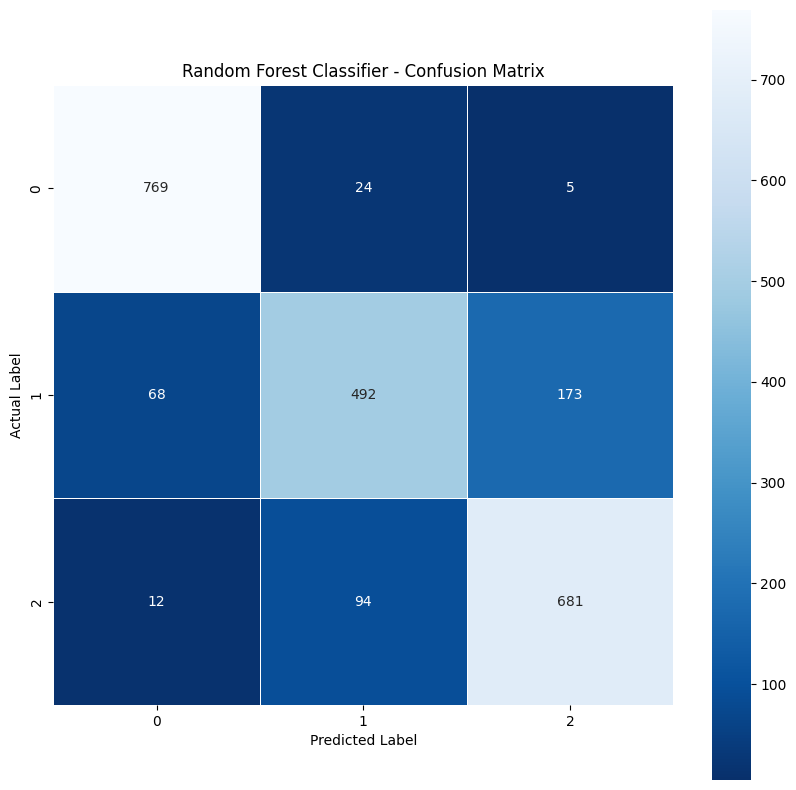

In [39]:
# Plotting the Confusion Matrix:
rfc_confusion_matrix = confusion_matrix(y_test, rfc_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(rfc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Random Forest Classifier - Confusion Matrix")
plt.show()

In [40]:
print("Classification Report For Random Forest Classifier:")
print('-' * 57)
print(classification_report(y_test, rfc_prediction))

Classification Report For Random Forest Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.91      0.96      0.93       798
     neutral       0.81      0.67      0.73       733
    positive       0.79      0.87      0.83       787

    accuracy                           0.84      2318
   macro avg       0.84      0.83      0.83      2318
weighted avg       0.84      0.84      0.83      2318



In [41]:
# save the random forest model
joblib.dump(rfc, 'Models/random_forest_model.pkl')

['Models/random_forest_model.pkl']

# 6. Gradient Boosting Classifier


In [42]:
print("Evaluation for: Gradient Boosting Classifier".center(57, '_'))

gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

gbc_prediction = gbc.predict(X_test)
gbc_accuracy_score = accuracy_score(y_test, gbc_prediction)
gbc_precision_score = precision_score(
    y_test, gbc_prediction, average="weighted")
gbc_recall_score = recall_score(y_test, gbc_prediction, average="weighted")
gbc_f1_score = f1_score(y_test, gbc_prediction, average="weighted")

print(f"Model Type: {gbc}")
print(f"Prediciton: {gbc_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(gbc_accuracy_score):%}")
print(f"Precision Score: {(gbc_precision_score):%}")
print(f"Recall Score:    {(gbc_recall_score):%}")
print(f"F1-Score:        {(gbc_f1_score):%}")

_______Evaluation for: Gradient Boosting Classifier______
Model Type: GradientBoostingClassifier()
Prediciton: ['neutral' 'neutral' 'negative' ... 'negative' 'positive' 'neutral']
---------------------------------------------------------
Accuracy Score:  87.618637%
Precision Score: 88.069934%
Recall Score:    87.618637%
F1-Score:        87.737190%


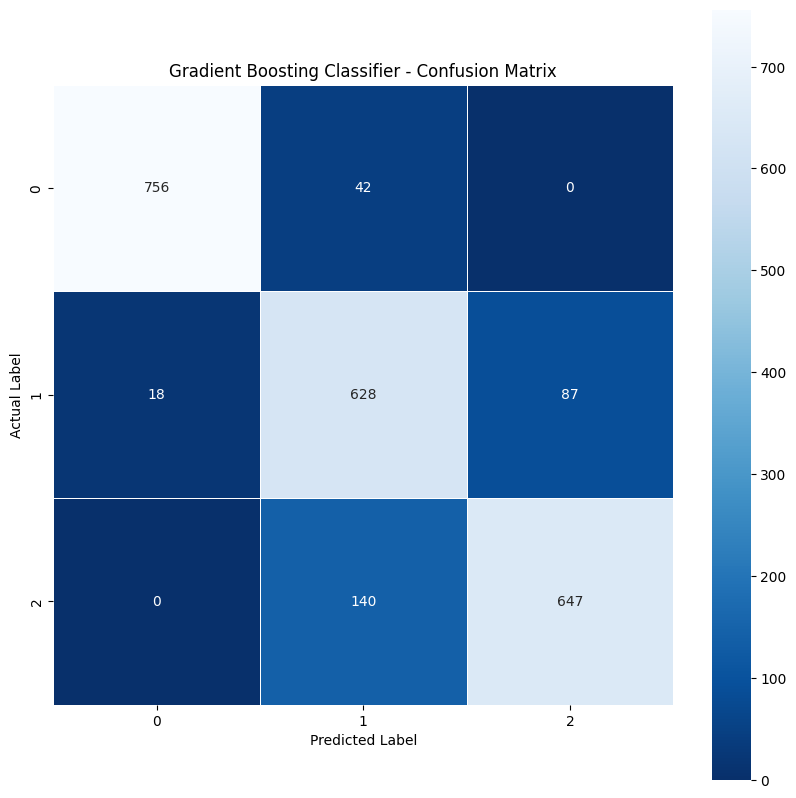

In [43]:
# Plotting the Confusion Matrix:
gbc_confusion_matrix = confusion_matrix(y_test, gbc_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(gbc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Gradient Boosting Classifier - Confusion Matrix")
plt.show()

In [44]:
print("Classification Report For Gradient Boosting Classifier:")
print('-' * 57)
print(classification_report(y_test, gbc_prediction))

Classification Report For Gradient Boosting Classifier:
---------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.98      0.95      0.96       798
     neutral       0.78      0.86      0.81       733
    positive       0.88      0.82      0.85       787

    accuracy                           0.88      2318
   macro avg       0.88      0.88      0.88      2318
weighted avg       0.88      0.88      0.88      2318



In [45]:
# save the gradient boosting model
joblib.dump(gbc, 'Models/gradient_boosting_model.pkl')

['Models/gradient_boosting_model.pkl']

# 7. C-Support Vector Classifier


In [46]:
print("Evaluation for: C-Support Vector Classification".center(57, '_'))

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy_score = accuracy_score(y_test, svc_prediction)
svc_precision_score = precision_score(
    y_test, svc_prediction, average="weighted")
svc_recall_score = recall_score(y_test, svc_prediction, average="weighted")
svc_f1_score = f1_score(y_test, svc_prediction, average="weighted")

print(f"Model Type: {svc}")
print(f"Prediciton: {svc_prediction}")
print('-' * 57)

print(f"Accuracy Score:  {(svc_accuracy_score):%}")
print(f"Precision Score: {(svc_precision_score):%}")
print(f"Recall Score:    {(svc_recall_score):%}")
print(f"F1-Score:        {(svc_f1_score):%}")

_____Evaluation for: C-Support Vector Classification_____
Model Type: SVC()
Prediciton: ['neutral' 'positive' 'neutral' ... 'negative' 'positive' 'neutral']
---------------------------------------------------------
Accuracy Score:  87.834340%
Precision Score: 88.009451%
Recall Score:    87.834340%
F1-Score:        87.822582%


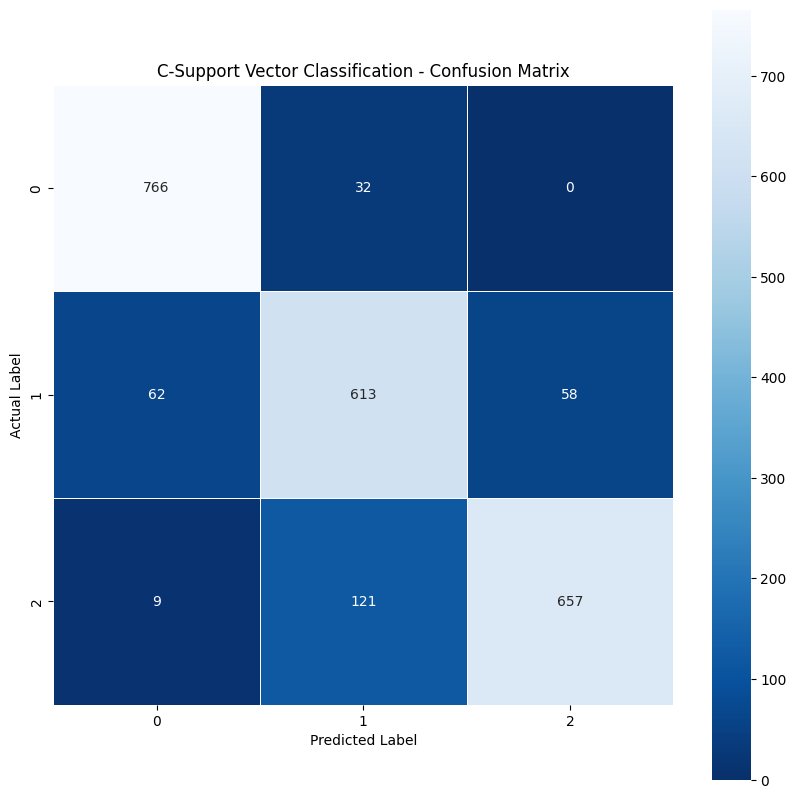

In [47]:
# Plotting the Confusion Matrix:
svc_confusion_matrix = confusion_matrix(y_test, svc_prediction)

plt.figure(figsize=(10, 10))
sns.heatmap(svc_confusion_matrix, annot=True, fmt=".0f",
            linewidths=0.7, square=True, cmap="Blues_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("C-Support Vector Classification - Confusion Matrix")
plt.show()

In [48]:
print("Classification Report For C-Support Vector Classification:")
print('-' * 63)
print(classification_report(y_test, svc_prediction))

Classification Report For C-Support Vector Classification:
---------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94       798
     neutral       0.80      0.84      0.82       733
    positive       0.92      0.83      0.87       787

    accuracy                           0.88      2318
   macro avg       0.88      0.88      0.88      2318
weighted avg       0.88      0.88      0.88      2318



In [49]:
# save the c-support vector model
joblib.dump(svc, 'Models/c_support_vector_model.pkl')

['Models/c_support_vector_model.pkl']

## <center><u>Visualising the Metric Scores for all Classifier Models</u></center>


In [50]:
lgc_scores = [lgc_acc*100, lgc_prec*100, lgc_rec*100, lgc_f1*100]
abc_scores = [abc_accuracy_score*100, abc_precision_score*100,
              abc_recall_score*100, abc_f1_score*100]
knn_scores = [knn_accuracy_score*100, knn_precision_score*100,
              knn_recall_score*100, knn_f1_score*100]
dtc_scores = [dtc_accuracy_score*100, dtc_precision_score*100,
              dtc_recall_score*100, dtc_f1_score*100]
rfc_scores = [rfc_accuracy_score*100, rfc_precision_score*100,
              rfc_recall_score*100, rfc_f1_score*100]
gbc_scores = [gbc_accuracy_score*100, gbc_precision_score*100,
              gbc_recall_score*100, gbc_f1_score*100]
svc_scores = [svc_accuracy_score*100, svc_precision_score*100,
              svc_recall_score*100, svc_f1_score*100]

x_grid = ["Accuracy", "Precision", "Recall", "F1-Score"]
y_grid = [value for value in range(1, 120, 10)]
xpos = np.arange(len(x_grid))
bar_width = .10

plt.figure(figsize=(20, 10), dpi=700, facecolor='w', edgecolor='k')
plt.title("Model Evaluation Scores", fontsize=20)
# Function to add value labels on the bars


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.2f}%', ha='center', va='bottom', rotation=90)


# Create bars and add labels
bars_lgc = plt.bar(xpos, lgc_scores, width=bar_width,
                   label="Logistic Regression")
add_labels(bars_lgc)

bars_abc = plt.bar(xpos + bar_width, abc_scores,
                   width=bar_width, label="AdaBoost")
add_labels(bars_abc)

bars_knn = plt.bar(xpos + bar_width*2, knn_scores,
                   width=bar_width, label="K-Neighbors")
add_labels(bars_knn)

bars_dtc = plt.bar(xpos + bar_width*3, dtc_scores,
                   width=bar_width, label="Decision Tree")
add_labels(bars_dtc)

bars_rfc = plt.bar(xpos + bar_width*4, rfc_scores,
                   width=bar_width, label="Random Forest")
add_labels(bars_rfc)

bars_gbc = plt.bar(xpos + bar_width*5, gbc_scores,
                   width=bar_width, label="Gradient Boosting")
add_labels(bars_gbc)

bars_svc = plt.bar(xpos + bar_width*6, svc_scores,
                   width=bar_width, label="C-Support Vector")
add_labels(bars_svc)

plt.xticks(xpos + bar_width*3, x_grid, fontsize=15)
plt.yticks(y_grid, fontsize=15)
plt.xlabel("Evaluation Metrics", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.legend(bbox_to_anchor=(1.15, 1), borderaxespad=0.)
plt.show()

In [1]:
import pandas as pd

# 1) Read the CSV from your local project directory using latin-1 encoding
df_uploaded = pd.read_csv(
    'Dataset/Cleaned Data/reviews.csv',  # <-- this is your actual file path
    sep=',',
    quotechar='"',
    encoding='latin-1'
)

# 2) Check the columns to ensure pandas parsed them correctly
print(df_uploaded.columns)   # should print ['date', 'reviewer_name', 'comments', 'cleaned_comments', 'polarity', 'sentiment']
df_uploaded.head()


Index(['date', 'reviewer_name', 'comments', 'cleaned_comments', 'polarity',
       'sentiment'],
      dtype='object')


,date,reviewer_name,comments,cleaned_comments,polarity,sentiment
0,2016-08-20,Jenny,"Die Unterkunft war wirklicht toll, ruhig, nett...",die unterkunft war wirklicht toll ruhig nett z...,-0.7,negative
1,2023-01-08,Elia,"El apartamento estaba correcto, tal cual, como...",el apartamento estaba correcto tal cual como e...,-0.6,negative
2,2023-05-02,Cecilia,Yo buscaba estar cerca de la estaciÃ³n de Live...,yo buscaba estar cerca de la estaciÃ³n de live...,-0.6,negative
3,2018-11-25,Sibylle,"Elisas Wohnung liegt in Hampsted, mehrere Busl...",elisa wohnung liegt hampst mehrer buslinien ha...,-0.7,negative
4,2018-02-18,Nathalie,Ich habe meinen Aufenthalt bei Hedge und Britt...,ich habe meinen aufenthalt bei hedg und britt ...,-0.7,negative
